# 12. 분류
- 1990년 대 1세대 스팸 메일 필터가 유명해지면서, 분류는 가장 유명한 베이지안 방식 활용 기법이 됨

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params

set_pyplot_params()

In [2]:
from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

In [4]:
import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + marker_cycle + line_cycle)

<br>

## 12.01. 펭귄 데이터

In [25]:
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style = 'whitegrid')

df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [26]:
def shorten(species):
    return species.split()[0]

df['species2'] = df['species'].apply(shorten)

- 데이터 셋에는, Adelie, Chinstrap, Gentoo 세 종의 펭귄 데이터가 포함


<img width="400" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAWkZ0U4AA1CQf.jpeg" alt="Drawing of three penguin species">

사용할 측정치

* 체중 (g) : body_mass_g

* 발 길이 (mm) : flipper_length_mm

* 부리 상부 길이 (mm) : bill_length_mm

* 부리 상부 폭 (mm) : bill_depth_mm



<img width="300" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAXQn8U4AAoKUj.jpeg">

<br>

이 측정치는, 종 간 차이가 분명하고, 동일한 종의 경우에는 분산이 작아 분류에 사용하기에 유용

<br>

#### 각 측정치별로 누적분포함수

In [27]:
from empiricaldist import Cdf
from utils import decorate

In [28]:
def make_cdf_map(df, colname, by='species2'):
    
    """각 종에 대한 CDF"""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
        
    return cdf_map

In [29]:
def plot_cdfs(df, colname, by='species2'):
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')
    
    decorate(xlabel=colname, ylabel='CDF')

<br>

#### 부리 상부 길이
* 부리 상부길이를 사용해서 Adelie 종을 구분하는 것은 가능할 것 같지만, 나머지 두 종의 분포는 거의 같음

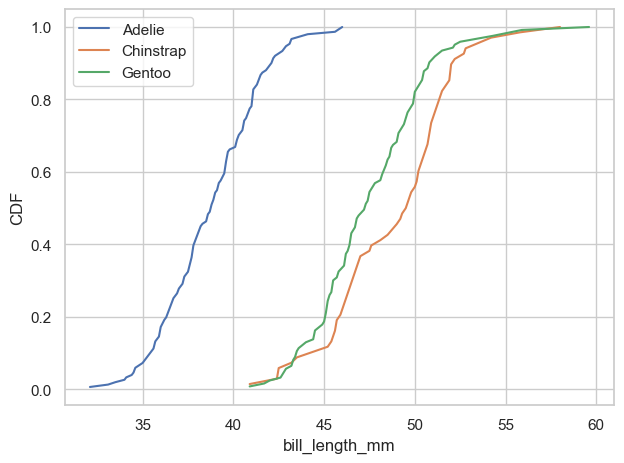

In [38]:
colname = 'bill_length_mm'
plot_cdfs(df, colname)

<br>

#### 발 길이 분포
* Gentoo 종과 다른 두 종을 구분할 수 있음

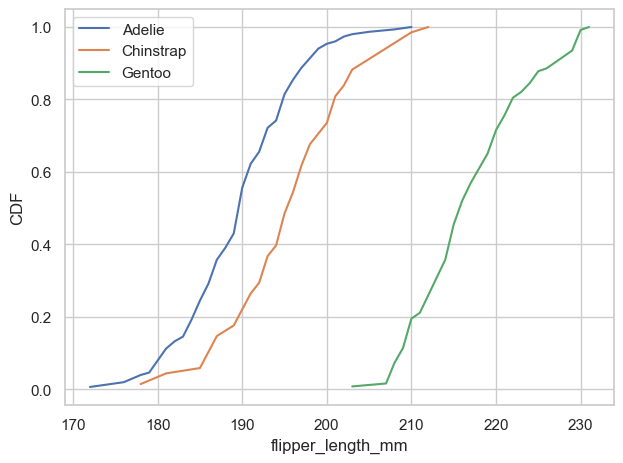

In [36]:
colname = 'flipper_length_mm'
plot_cdfs(df, colname)

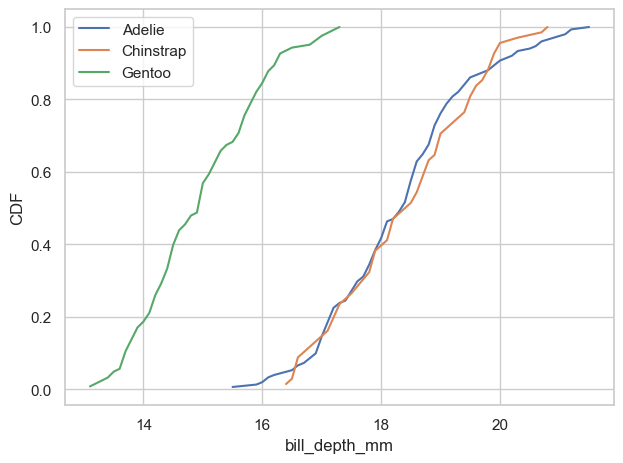

In [34]:
colname = 'bill_depth_mm'
plot_cdfs(df, colname)

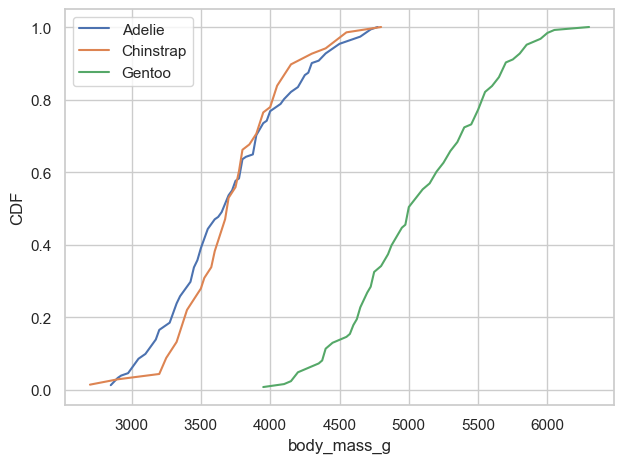

In [37]:
colname = 'body_mass_g'
plot_cdfs(df, colname)

#### 모든 CDF가 정규분포의 특징인 시그모이드 형태를 보임 

<br>

## 12.02. 정규 모델

베이지안 방식의 접근

1. 세 가능한 종에 대한 사전분포와, 각 종에 대한 사전확률을 정의

2. 각 종에 대한 가설에 대해 데이터의 가능도를 구함

3. 각 가설에 대한 사후분포를 계산

<br>

**각 가설 하에서의 데이터의 가능도를 구하기 위해, 각 종에 대한 정규분포의 매개변수를 추정**

- 각 종의 이름과 norm객체를 연결한 딕셔너리를 반환

In [42]:
from scipy.stats import norm

def make_norm_map(df, colname, by='species'):
    """종과 norm객체를 연결"""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
        
    return norm_map

In [43]:
flipper_map = make_norm_map(df, 'flipper_length_mm')
flipper_map.keys()

dict_keys(['Adelie', 'Chinstrap', 'Gentoo'])

<br>

### 가능도
**펭귄의 신체를 측정해서, 발길이가 193mm임을 알았을 때, 각 가설하에서 이 측정치가 맞을 확률 (가능도)**

In [55]:
data = 193

In [54]:
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.051721356158881626, 5.866045366199098e-05]

<br>

## 12.03. 갱신

#### 세 종이 발견될 가능성이 동일하다고 가정 (균등사전분포)

In [57]:
from empiricaldist import Pmf

In [58]:
prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


**사전분포갱신**

In [59]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


<br>

#### 발 길이가 193mm인 펭귄이 Gentoo일 가능성은 거의 업지만, Adelie펭귄이나 Chinstrap일 가능성은 비슷

<br>

*위 과정을 하나의 함수로*

In [62]:
def update_penguin(prior, data, norm_map):
    """가설 하에서의 종 분포를 갱신"""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    
    return posterior

In [63]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


<br>

#### CDF에서 봤던 대로, Adelie펭귄과 Chinstrap 펭귄은 발 길이로 뚜렷이 구분할 수 없음

<br>

<br>

### 부리 상단 길이의 분포에 대한 추정
- **부리 상단 길이가 48mm인 펭귄을 발견했을 때의 사전분포 갱신**

In [67]:
culmen_map = make_norm_map(df, 'bill_length_mm')

In [68]:
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,probs
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


#### 부리 상단 길이가 48mm인 펭귄은 거의 비슷한 확률로 Chinstrap 펭귄이거나, Gentoo 펭귄

<br>

## 12.04. 나이브 베이지안 분류

- 여러번의 갱신을 진행하는 함수

In [69]:
def update_naive(prior, data_seq, norm_maps):
    """나이브 베이지안 분류
    
    prior: Pmf
    data_seq: 측정값 순열
    norm_maps: 종에 분포를 연결한 순열
    
    returns: 사후분포를 나타내는 Pmf
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
        
    return posterior


<br>

#### 부리 상단 길이와, 발 길이가 각각 193mm, 48mm인 펭귄을 발견 $\rightarrow$ 거의 확실히 Chinstrap 펭귄으로 추측

In [71]:
colnames = ['flipper_length_mm', 'bill_length_mm']
norm_maps = [flipper_map, culmen_map]

In [72]:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


In [73]:
posterior.max_prob()

'Chinstrap'

<br>

### 반복문에 데이터 셋을 넣어, 두 특징을 사용해서 여러 펭귄을 분류
#### 이각 펭귄별로 최대 사후확률을 가지는 종 이름을 기록

In [85]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

- 정확도는 대략 95%

In [79]:
len(df)

344

In [80]:
valid = df['Classification'].notna()
valid.sum()

342

In [82]:
same = df['species'] == df['Classification']
same.sum()

324

In [34]:
same.sum() / valid.sum()

In [216]:
def accuracy(df):
    """분류 정확도 계산"""
    valid = df['Classification'].notna()
    same = df['species2'] == df['Classification']
    return same.sum() / valid.sum()

### 나이브 베이즈 분류기의 경우, 각 변수간의 연관성을 고려하지 않으므로 '나이브'라고 불림

<br>

## 12.05. 결합분포

#### **산점도를 통해, 부리 상부 길이와 발 길이 변수간 상관관계가 있음을 확인**

In [217]:
import matplotlib.pyplot as plt

In [218]:
def scatterplot(df, var1, var2):
    """Make a scatter plot."""
    grouped = df.groupby('species')
    for species, group in grouped:
        plt.scatter(group[var1], group[var2], label=species, alpha=0.5)
    
    decorate(xlabel=var1, ylabel=var2)

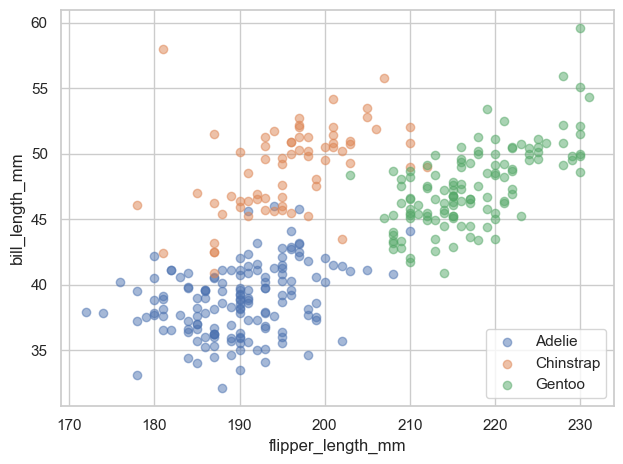

In [219]:
var1 = 'flipper_length_mm'
var2 = 'bill_length_mm'
scatterplot(df, var1, var2)

<br>

#### 만약 이 상관관계를 무시한다면, 각 변수는 독립적이라는 가정

<br>

### 각 변수가 서로 독립적이라고 가정 $\rightarrow$ 각 종별 두 변수의 결합분포를 생성

In [220]:
def make_pmf_norm(dist, sigmas=3, n=101):
    
    """정규분포에 근사하는 Pmf를 생성"""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    
    return pmf

#### 각 종의 부리 상부 길이와, 발 길이의 결합분포 생성

In [221]:
from utils import make_joint

In [222]:
hypos, flipper_map, culmen_map

(dict_keys(['Adelie', 'Chinstrap', 'Gentoo']),
 {'Adelie': <scipy.stats._distn_infrastructure.rv_frozen at 0x155185d7190>,
  'Chinstrap': <scipy.stats._distn_infrastructure.rv_frozen at 0x155186b3c10>,
  'Gentoo': <scipy.stats._distn_infrastructure.rv_frozen at 0x155186043a0>},
 {'Adelie': <scipy.stats._distn_infrastructure.rv_frozen at 0x15518656d30>,
  'Chinstrap': <scipy.stats._distn_infrastructure.rv_frozen at 0x155184da310>,
  'Gentoo': <scipy.stats._distn_infrastructure.rv_frozen at 0x1551862bbe0>})

In [223]:
joint_map = {}

for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

#### 독립성을 가정했을 때의 결합분포 경계선 및 산점도

In [224]:
from utils import plot_contour

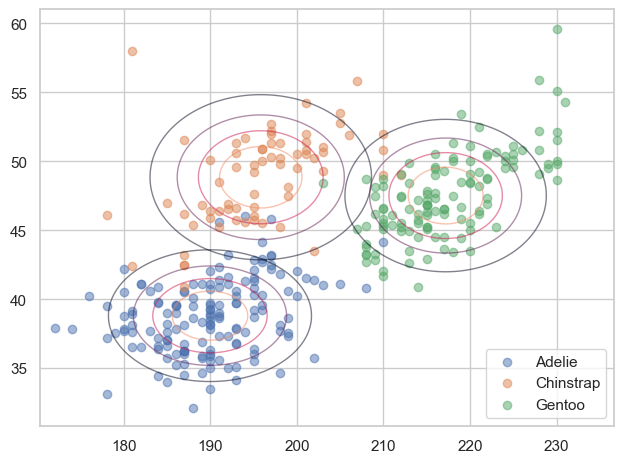

In [225]:
scatterplot(df, var1, var2)

for species in hypos:
    plot_contour(joint_map[species], alpha=0.5)

#### 결합 정규분포의 경계선은 타원형을 띔
#### 변수 간 연관성이 없다고 가정했기에, 타원이 축에 평행하게 배치됨

<br>

## 12.06. 다변량 정규분포

- 일변량 정규분포는 평균과 표준 편차로 정의 할 수 있음
- **하지만, 다변량 정규분포는 변수의 평균과, 각 변수의 값이 얼마나 퍼져 있는 지를 숫자로 나타낼 값인 분산과**

    **변수 간의 관계를 숫자로 나타낸 공분산이 들어 있는 공분산 행렬로 정의**
    
<br>

#### 펭귄에 대한 평균과 공분산행렬을 추정

In [226]:
features = df[[var1, var2]]

In [227]:
mean = features.mean()
mean

flipper_length_mm    200.915205
bill_length_mm        43.921930
dtype: float64

In [228]:
cov = features.cov()
cov

,flipper_length_mm,bill_length_mm
flipper_length_mm,197.731792,50.375765
bill_length_mm,50.375765,29.807054


#### 공분산행렬의 대각선 값은 분산, 그 외의 값은 공분산

<br>

#### `scipy.stats.multivariate_normal(mean, cov)` : `mean`을 평균으로, `cov`를 공분산으로 가지는 다변량 정규분포 객체 생성

In [229]:
from scipy.stats import multivariate_normal

In [230]:
multinorm = multivariate_normal(mean, cov)

#### 각 종별로 다변량 정규분포 객체 생성

In [231]:
def make_multinorm_map(df, colnames):
    """각 종과 다변량 정규분포를 연결하는 객체 생성"""
    multinorm_map = {}
    grouped = df.groupby('species')
    
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
        
    return multinorm_map

Here's how we make this map for the first two features, flipper length and culmen length.

In [232]:
multinorm_map = make_multinorm_map(df, [var1, var2])

In [233]:
multinorm_map

{'Adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x1551ae3fa90>,
 'Chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x1551abdceb0>,
 'Gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x15518767b50>}

<br>

### Adélie 펭귄의 특징 분포에 대한 등고선 지도

In [234]:
norm1 = flipper_map['Adelie']
norm2 = culmen_map['Adelie']
multinorm = multinorm_map['Adelie']

- 각 일변량 분포에 대해 이산적인 `Pmf` 근사치를 생성

In [235]:
pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2)

- 모든 값 쌍을 포함하는 메시 그리드 생성

In [236]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape, Y.shape

((101, 101), (101, 101))

- 각 값 쌍에 대한 다변량 분포를 평가

In [237]:
pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

결과는 쌍의 2차원 배열로 생각할 수 있는 3차원 배열

<br>


#### **이 배열을 `multinorm.pdf`에 전달 $\rightarrow$ 확률 밀도의 배열**

In [238]:
densities = multinorm.pdf(pos)
densities.shape

(101, 101)

#### 정규화 $\rightarrow$ 두 변수의 결합 분포에 대한 이산 근사치

In [239]:
from utils import normalize

In [240]:
joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
normalize(joint)

15.871343639913828

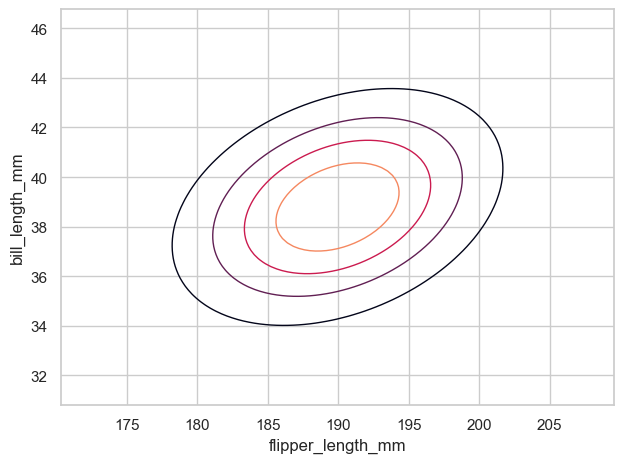

In [241]:
plot_contour(joint)
decorate(xlabel=var1, ylabel=var2)

#### 다변량 정규 분포의 윤곽은 여전히 타원이지만 이제 특성 간의 상관 관계를 고려했으므로 타원은 더 이상 축과 정렬되지 않음

<br>

*위의 절차를 하나의 함수로*

In [242]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: 첫 번째 특성의 분포를 나타내는 `norm` 객체
    norm2: 두 번째 특성의 분포를 나타내는 `norm` 객체
    multinorm: 결합 분포를 나타내는 `multivariate_normal` 객체
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

#### 각 종에 대한 다변량 정규분포의 경계선과 데이터의 산점도

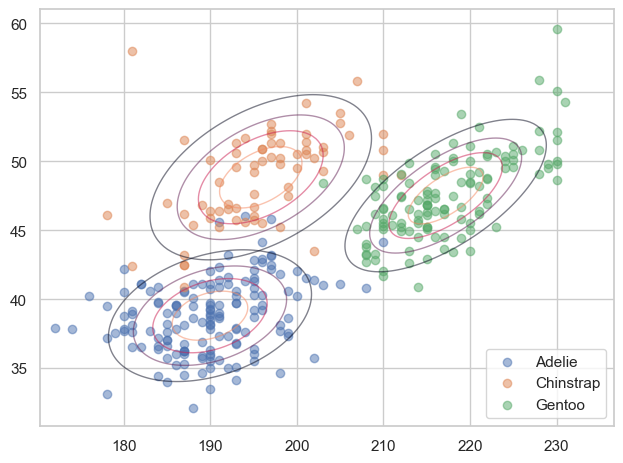

In [243]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.5)

#### 다변량 정규분포는 특징 간의 상관관계를 고려 

#### $\rightarrow$ 분포 간의 경계선 간에 겹치는 부분이 감소 

#### **$\rightarrow$ 성능 증가**

<br>

## 12.07. 덜 나이브한 분류기
- 정확도가 조금 향상

In [244]:
def update_penguin(prior, data, norm_map):
    
    """가설 하의 종 분포를 갱신"""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    
    return posterior

In [245]:
data = 193, 48
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


In [246]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

In [247]:
accuracy(df)

0.9532163742690059